In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFE
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tempfile
import pickle
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, roc_auc_score

In [4]:
# Function to calculate average F1 score and accuracy
def calculate_metrics(confusion_matrices):
    all_f1_weighted = []
    all_f1_macro = []
    all_accuracies = []

    for cm in confusion_matrices:
        true_labels = []
        predicted_labels = []
        
        for actual_class in range(len(cm)):
            for predicted_class in range(len(cm[actual_class])):
                true_labels.extend([actual_class] * cm[actual_class][predicted_class])
                predicted_labels.extend([predicted_class] * cm[actual_class][predicted_class])
        
        f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
        f1_macro = f1_score(true_labels, predicted_labels, average='macro')
        accuracy = accuracy_score(true_labels, predicted_labels)

        all_f1_weighted.append(f1_weighted)
        all_f1_macro.append(f1_macro)
        all_accuracies.append(accuracy)

    average_f1_weighted = np.mean(all_f1_weighted)
    average_f1_macro = np.mean(all_f1_macro)
    average_accuracy = np.mean(all_accuracies)

    return average_f1_weighted, average_f1_macro, average_accuracy

In [5]:
# Function to plot confusion matrix with percentages and save it
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', filename='confusion_matrix.png'):
    # Calculate percentages column-wise
    cm_sum = np.sum(cm, axis=0, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    # Create new confusion matrix with counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = '0\n0.0%'
            else:
                annot[i, j] = f'{c}\n{p:.1f}%'
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_perc_df = pd.DataFrame(cm_perc, index=labels, columns=labels)
    
    # Add Total Predicted and Total Actual
    total_actual = cm.sum(axis=1)
    total_predicted = cm.sum(axis=0)
    cm_df['Total Actual'] = total_actual
    cm_df.loc['Total Predicted'] = np.append(total_predicted, np.sum(total_predicted))
    
    total_actual_perc = total_actual / total_actual.sum() * 100
    total_predicted_perc = total_predicted / total_predicted.sum() * 100
    cm_perc_df['Total Actual'] = total_actual_perc
    cm_perc_df.loc['Total Predicted'] = np.append(total_predicted_perc, 100.0)
    
    # Prepare annotations with totals
    annot_df = cm_df.astype(str) + '\n' + cm_perc_df.round(2).astype(str) + '%'

    # Increase font size globally
    plt.rcParams.update({'font.size': 13, 'font.weight': 'bold'})
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=annot_df, fmt='', cmap='Blues', cbar=False, xticklabels=list(cm_df.columns), yticklabels=list(cm_df.index),
                annot_kws={"size": 31})
    
    # Highlight the Total columns and rows with white background
    for _, spine in plt.gca().spines.items():
        spine.set_visible(True)
    plt.gca().add_patch(plt.Rectangle((cm.shape[1], 0), 1, cm.shape[0], fill=True, facecolor='white', edgecolor='black', lw=1))
    plt.gca().add_patch(plt.Rectangle((0, cm.shape[0]), cm.shape[1], 1, fill=True, facecolor='white', edgecolor='black', lw=1))
    
    # Set title and labels
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=25)
    plt.ylabel('Actual Label', fontsize=25)
    
    # Save the figure
    plt.savefig(filename)
    plt.show()

Feature ranking (XGBoost):
Absolute Beta Power: 0.33821457624435425
Multiscale Entropy: 0.17083388566970825
Mean HR: 0.12430162727832794
Minimum HR: 0.12027617543935776
Mean Amplitude: 0.08832794427871704
Median Amplitude: 0.0838301032781601
Low Frequency Power: 0.07421577721834183


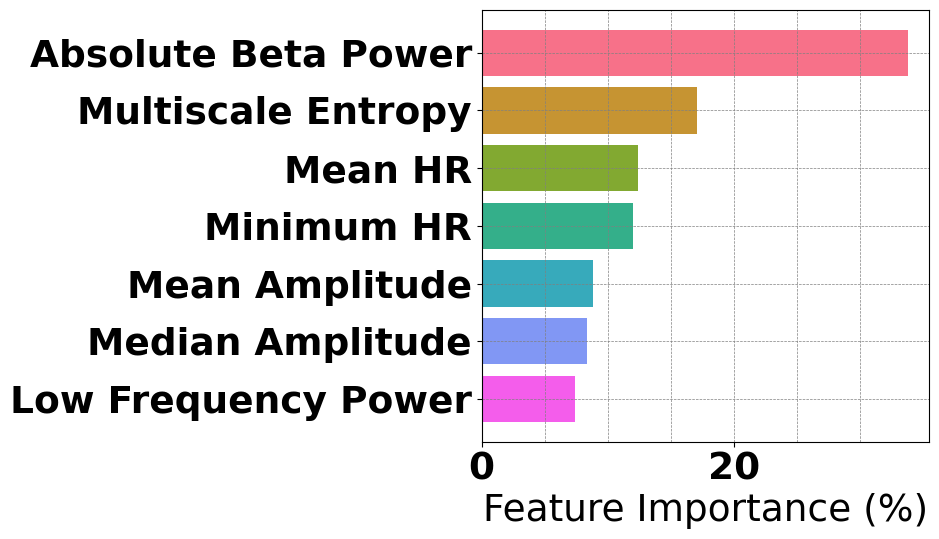

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Updated feature importance ranking for XGBoost
importances_xgb = np.array([
    0.33821457624435425, 0.17083388566970825, 0.12430162727832794,
    0.12027617543935776, 0.08832794427871704, 0.0838301032781601,
    0.07421577721834183
])
best_features_xgb = np.array([
    'Absolute Beta Power', 'Multiscale Entropy', 'Mean HR', 'Minimum HR', 'Mean Amplitude',
     'Median Amplitude', 'Low Frequency Power'
])
indices_xgb = np.argsort(importances_xgb)[::-1]
feature_ranking_xgb = {best_features_xgb[i]: importances_xgb[i] for i in indices_xgb}

print("Feature ranking (XGBoost):")
for feature, importance in feature_ranking_xgb.items():
    print(f"{feature}: {importance}")

# Convert importances to percentages
total_importance_xgb = sum(importances_xgb)
importances_xgb_perc = [(imp / total_importance_xgb) * 100 for imp in importances_xgb]

# Increase font size
plt.rcParams.update({'font.size': 27, 'font.weight': 'bold'})  # Adjust the font size here
# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
colors = sns.color_palette('husl', len(best_features_xgb))
plt.barh(range(len(best_features_xgb)), importances_xgb_perc, color=colors, align='center')
plt.yticks(range(len(best_features_xgb)), best_features_xgb[indices_xgb])
plt.xlabel('Feature Importance (%)')

# Add more crosshair lines
for i in range(len(best_features_xgb)):
    plt.axhline(y=i, color='grey', linestyle='--', linewidth=0.5)  # Horizontal lines

for x in np.arange(0, max(importances_xgb_perc) + 1, 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)  # Vertical lines

plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.savefig("E:/IEEE Sensor/Figures/XGBoost_all.png")
plt.show()


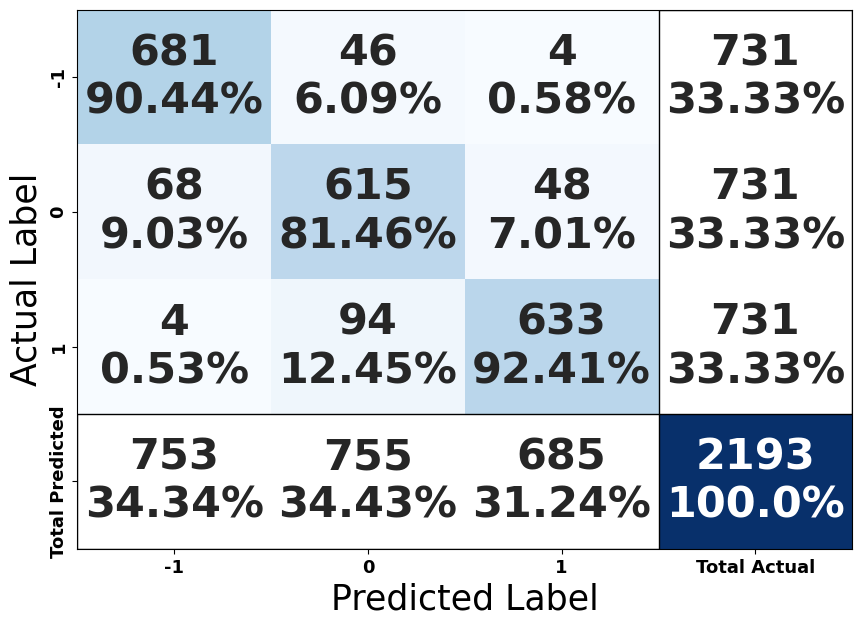

Average F1 Score (Weighted): 0.8768
Average F1 Score (Macro): 0.8768
Average Accuracy: 0.8790


In [6]:
# Load the confusion matrices from the pickle file
with open("E:/IEEE Sensor/IEEE Sensor Xlsx Data/xgb_confusion_matrices.pkl", "rb") as f:
    confusion_matrices = pickle.load(f)

# Aggregate confusion matrices
aggregated_cm = np.sum(confusion_matrices, axis=0)
labels = [-1, 0, 1]

# Plot the aggregated confusion matrix
plot_confusion_matrix(aggregated_cm, labels, title='', filename='E:/IEEE Sensor/Figures/xgb_confusion_matrices.png')

# Calculate and print the average F1 scores and accuracy
average_f1_weighted, average_f1_macro, average_accuracy = calculate_metrics(confusion_matrices)
print(f'Average F1 Score (Weighted): {average_f1_weighted:.4f}')
print(f'Average F1 Score (Macro): {average_f1_macro:.4f}')
print(f'Average Accuracy: {average_accuracy:.4f}')

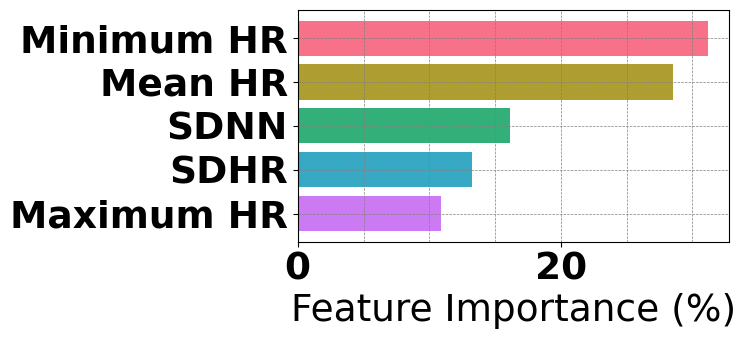

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Updated feature ranking (XGBoost)
features_xgb = ['Minimum HR', 'Mean HR', 'SDNN', 'SDHR', 'Maximum HR']
importances_xgb = [
    0.3121756911277771, 0.2854834496974945, 0.16105619072914124, 
    0.1325186938047409, 0.1087660863995552
]

# Convert importances to percentages
importances_xgb_perc = [imp * 100 for imp in importances_xgb]

# Increase font size
plt.rcParams.update({'font.size': 27, 'font.weight': 'bold'})  # Adjust the font size here
plt.figure(figsize=(8, 4))
#plt.title("Feature Importance (XGBoost), use ECG")
colors = sns.color_palette('husl', len(features_xgb))
plt.barh(range(len(features_xgb)), importances_xgb_perc, color=colors, align='center')
plt.yticks(range(len(features_xgb)), features_xgb)
plt.xlabel('Feature Importance (%)')
#plt.ylabel('Feature')

# Add more crosshair lines
for i in range(len(features_xgb)):
    plt.axhline(y=i, color='grey', linestyle='--', linewidth=0.5)  # Horizontal lines

for x in np.arange(0, max(importances_xgb_perc), 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)  # Vertical lines

plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.savefig("E:/IEEE Sensor/Figures/XGBoost_ECG.png")
plt.show()


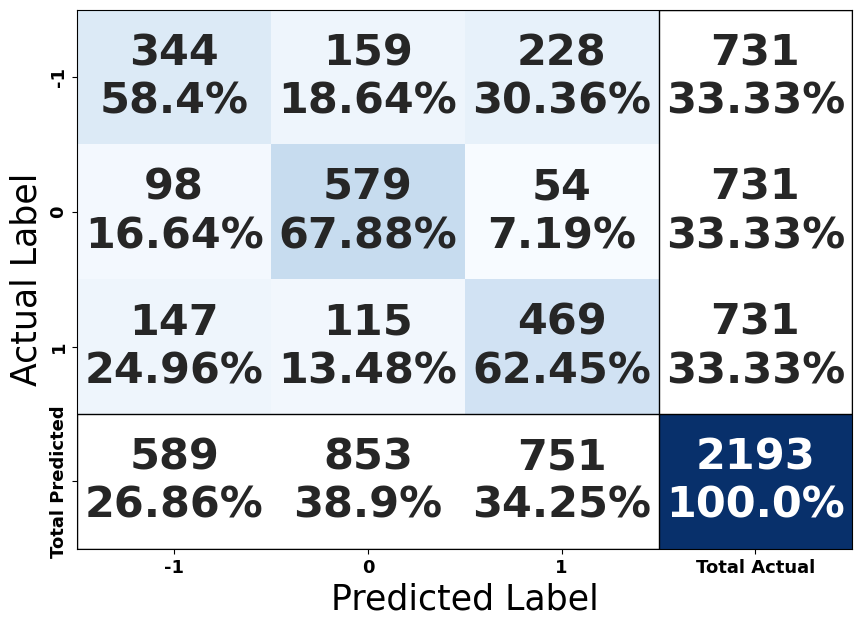

Average F1 Score (Weighted): 0.6257
Average F1 Score (Macro): 0.6257
Average Accuracy: 0.6397


In [7]:
# Load the confusion matrices from the pickle file
with open("E:/IEEE Sensor/IEEE Sensor Xlsx Data/xgb_confusion_matrices_no_EEG_EMG.pkl", "rb") as f:
    confusion_matrices = pickle.load(f)

# Aggregate confusion matrices
aggregated_cm = np.sum(confusion_matrices, axis=0)
labels = [-1, 0, 1]

# Plot the aggregated confusion matrix
plot_confusion_matrix(aggregated_cm, labels, title='', filename='E:/IEEE Sensor/Figures/xgb_confusion_matrices_no_EEG_EMG.png')

# Calculate and print the average F1 scores and accuracy
average_f1_weighted, average_f1_macro, average_accuracy = calculate_metrics(confusion_matrices)
print(f'Average F1 Score (Weighted): {average_f1_weighted:.4f}')
print(f'Average F1 Score (Macro): {average_f1_macro:.4f}')
print(f'Average Accuracy: {average_accuracy:.4f}')